<a href="https://colab.research.google.com/github/adewoleopeyemi/Deep-Dream/blob/master/DeepDream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
uploaded = files.upload()

Saving images (1).jpg to images (1) (1).jpg




*   List item
*   List item



In [0]:
test_image = uploaded['images (1).jpg']

In [0]:
from keras.applications import inception_v3
from keras.preprocessing import image as imagek
from keras import backend as K
from PIL import Image
import io



#We won't be trianing the model, so this command disables all training
#specific operations


K.set_learning_phase(0)
#Builds the inception V3 network, without its convolutional base, The model 
# will be loaded with pretrained weights
model = inception_v3.InceptionV3(weights = "imagenet", include_top = False)


#Dictionary mapping layer names to a coefficient quantifying how much the 
#layer"s activation contributes to the loss we seek to maximize.Note that 
#the layer names are hardcoded in the built-in-inception V3 application.
#You can list all layer names using model.summary()
layer_contributions = {
    "mixed2": 0.2,
    "mixed3": 3.,
    "mixed4": 2.,
    "mixed5": 1.5
}
#Loss is the weighted L2 sum of the activations in all the layers

#Creates a dictionary that maps layer names to layer instances
layer_dict = dict([(layer.name, layer) for layer in model.layers])
loss = K.variable(0.)

for layer_names in layer_contributions:
  coeff = layer_contributions[layer_names]
  
  #retrieves the output of the layer
  activation = layer_dict[layer_names].output
  scaling = K.prod(K.cast(K.shape(activation), "float32"))
  
  #Adds the L2 norm of the features of a layer to the loss
  loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling


#This tensor holds the generated image: the dream
dream = model.input

#computes the gradient of the dream with regards to the loss
grads = K.gradients(loss, dream)[0]

#Normalizes the mean
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
  outs = fetch_loss_and_grads([x])
  loss_value = outs[0]
  grads_value = outs[1]
  return loss_value, grads_value


#This function runs gradient ascent for a number of iterations
def gradient_ascent(x, iterations, step, max_loss = None):
  for i in range(iterations):
    loss_value, grad_value = eval_loss_and_grads(x)
    if max_loss is not None and loss_value > max_loss:
      break
    print("...Loss value at ", i, ":", loss_value)
    x += step * grad_value
  return x


import scipy 
from keras.preprocessing import image

def resize_img(img, size):
  img = np.copy(img)
  factors = (1, 
             float(size[0])/img.shape[1], 
             float(size[1])/img.shape[2], 
             1)
  return scipy.ndimage.zoom(img, factors, order = 1)

#util function to open, resize and format pictures into tensors that 
#inception V3 can process
def process_image(image):
  img = Image.open(io.BytesIO(image))
  img = imagek.img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  img = inception_v3.preprocess_input(img)
  return img

#util function to cinvert a rensor into a valid image
def deprocess_image(x):
  if K.image_data_format() == "channels_first":
    x = x.reshape((3, x.shape[2], x.shape[3]))
    x = x.transpose((1, 2, 0))
  else:
    #undoes preprocesing that was performed by inception_v3.preprocess_input
    x = x.reshape((x.shape[1], x.shape[2], 3))

  x /=2
  x += 0.5
  x *= 255
  x = np.clip(x, 0, 255).astype("uint8")
  return x

def save_img(image, fname):
  pil_img = deprocess_image(np.copy(img))
  scipy.misc.imsave(fname, pil_img)


Using TensorFlow backend.


In [0]:
import matplotlib.pyplot as plt

import numpy as np
#Gradient ascent step size
step = 0.5

#Number of scales at which to run gradient ascent
num_octaves = 3

#Size of ratio between scales
octave_scale = 1.4

#Number of times to run gradient ascent
iterations = 20

#if the loss grows larger than 10, we will interupt the gradient ascent
#process to avoid ugly artifacts
max_loss  = 12.

img = process_image(test_image)
original_shape = img.shape[1:3]
successive_shape = [original_shape]
for i in range(1, num_octaves):
  shape = tuple([int(dim/(octave_scale ** i))
    for dim in original_shape])
  successive_shape.append(shape)

successive_shape = successive_shape[::-1]
original_img = resize_img(img, successive_shape[0])
shrunk_original_image = resize_img(img, successive_shape[0])

for shape in successive_shape:
  print("Precessing image shape", shape)
  img = resize_img(img, shape)
  img = gradient_ascent(img, iterations = iterations, step = step, max_loss= max_loss)
  upscaled_shrunk_original_img = resize_img(shrunk_original_image, shape)
  same_size_original = resize_img(original_img, shape)
  lost_detail = same_size_original - upscaled_shrunk_original_img

  img += lost_detail
  print(img.shape)

Precessing image shape (114, 114)
...Loss value at  0 : 0.23496929
...Loss value at  1 : 2.0825505
(1, 114, 114, 3)
Precessing image shape (160, 160)
(1, 160, 160, 3)
Precessing image shape (225, 225)
(1, 225, 225, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


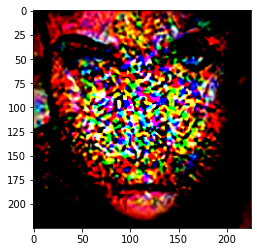

In [0]:
  img = img.reshape(225, 225, 3)
  plt.imshow(img)